In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import pandas as pd
from scipy.stats import chisqprob
import pylab as pb

In [2]:
def build_XI(input_list):
    num_outputs = len(input_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,I

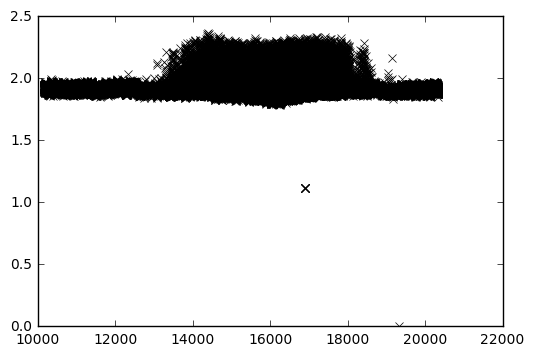

In [26]:
# mat_file1 = io.loadmat('2014_Dataset1.mat')
# t = mat_file1['t']
# p1 = mat_file1['p1']
# p2 = mat_file1['p2']
# x = np.arange(0,len(p2)/10,0.1)[:,None]
# plt.plot(x,p2,'kx')
# plt.show()
# for i in range(len(x)-1):
#     if p2[i]<190:
#         print (i)

mat_file2 = pd.read_csv('dataset 781.csv')
p1 = np.array(mat_file2['P1'])[:,None]
p2 = np.array(mat_file2['P2'])[:,None]
x = np.arange(0,len(p2)/10,0.1)[:,None]
# for i in range(len(p2)):
#     if p2[i]<5:
#         p2[i] = p2[i]*100
# plt.ylim([0,1])
plt.plot(x[101682:203384],p2[101682:203384],'kx')
plt.show()

In [27]:
import pickle
f = open('d:/hyperparameter6_2015','rb')
gp = pickle.load(f)
f.close()

In [29]:
Month = []
for i in range(len(mat_file2)):
    if mat_file2['Day'][i] == 1 and mat_file2['Hour'][i] == 0 and mat_file2['Minute'][i]==0:
        Month.append(i)
# Mon = list(Month)[1:10]+[86897]+[92773]+[Month[11]]
Mon = list(Month[11:23])
mat_file2.loc[Mon,:]

,HISTID,Year,Month,Day,Hour,Minute,P1,P2
101682,781,2015,1,1,0,0,0.599,1.919
110568,781,2015,2,1,0,0,0.602,1.937
117969,781,2015,3,1,0,0,0.605,1.916
126050,781,2015,4,1,0,0,0.610,1.901
133995,781,2015,5,1,0,0,0.606,1.882
142923,781,2015,6,1,0,0,0.611,1.882
151563,781,2015,7,1,0,0,0.611,1.885
160489,781,2015,8,1,0,0,0.609,1.833
169417,781,2015,9,1,0,0,0.610,1.989
178057,781,2015,10,1,0,0,0.607,1.896


In [30]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    
    plt.xlabel('X',fontsize=16)
    plt.ylabel('Y',fontsize=16)
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)
    ax1.legend(loc=3)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)
    ax2.legend(loc=3)

# EVT-GP


In [31]:
def rbf(X,xt,m):
    Xt = xt*np.ones(len(X))[:,None]
    k = ((X-Xt)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    n = np.sum(ke)
    return n

def z_score(n):
    alpha = (2*np.log(n))**(-0.5)
    beta = (2*np.log(n))**(0.5) - (np.log(np.log(n))+np.log(2*np.pi))/(2*(2*np.log(n))**0.5)
    zp = beta-alpha*np.log(-np.log(0.98))
    return zp

def Mahalanobis_distance(model,x_test,y2):
    X,I = build_XI([x_test,x_test])
    mean, variance = model.predict(X, full_cov=True, Y_metadata=I)
    l = len(x_test)
    MD2 = np.dot(np.dot(np.transpose(y2-mean[l:2*l]),np.linalg.inv(variance[l:2*l,l:2*l])),y2-mean[l:2*l])

    return MD2

kern = gp.kern.copy()

In [33]:
s = Mon[0]
l = 120

it = list(range(s,s+l))
kt = it.copy()
anomal_points = []
test_points = []
test_points2 = []
chi_sq = []
con_bd = []
step = 1

for i in range(Mon[1]-Mon[0]-l):
    # 기존 100개 model에 z 구하기
    new = it[len(it)-1]+step
    test_points.append(new)
    
    mul = GPy.models.GPCoregionalizedRegression([x[kt],x[it]],[p1[kt],p2[it]],kernel = kern)
    mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    print(new)
    # pointwise detection
   
    test_x = x[new]
    n = rbf(x[it],test_x,mul)
    zp = z_score(n)

    # 벗어나는 x찾기
    jt = it + list([new])
    X,I = build_XI([x[jt],x[jt]])
    mu,var = mul.predict(X,Y_metadata=I,kern=mul.kern,likelihood=mul.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]
    
    con_ue = mu2 + np.sqrt(var2)*zp
    con_le = mu2 - np.sqrt(var2)*zp

    if i == 0:
        for j in range(len(con_ue)):
            con_bd.append([con_ue[j],con_le[j]])
            test_points2.append([jt[j],jt[j]])
    else:
        con_bd.append([con_ue[len(con_ue)-1],con_le[len(con_le)-1]])
        test_points2.append([new,new])
  
    if p2[new] > mu2[l] + zp*np.sqrt(var2[l]) or p2[new] < mu2[l] - zp*np.sqrt(var2[l]):
        anomal_points.append(new)
        it = it
        kt = kt + list([new])
        step += 1
    else:
        it.pop(0)
        it = it + list([new])
        kt.pop(0)
        kt = kt + list([new])
        step = 1
        
    # trajectory detection    
    
    mul2 = GPy.models.GPCoregionalizedRegression([x[kt],x[it[0:len(it)-12]]],[p1[kt],p2[it[0:len(it)-12]]],kernel = kern)
    mul2['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul2['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    ct = it[len(it)-12:len(it)]
    md2 = Mahalanobis_distance(mul2,x[ct],p2[ct])
    cs = chisqprob(md2,len(ct))[0][0]
    chi_sq.append(cs)
#     if cs <0.02:
#         plot_2outputs(mul2, xlim=(x[kt[0]],x[kt[len(kt)-1]]),x_1=x[kt],x_2=x[it[0:len(it)-12]])
#         plt.plot(x[ct],p2[ct],'kx')
#         plt.show()

101802
101803
101804
101805
101806
101807
101808
101809
101810
101811
101812
101813
101814
101815
101816
101817
101818
101819
101820
101821
101822
101823
101824
101825
101826
101827
101828
101829
101830
101831
101832
101833
101834
101835
101836
101837
101838
101839
101840
101841
101842
101843
101844
101845
101846
101847
101848
101849
101850
101851
101852
101853
101854
101855
101856
101857
101858
101859
101860
101861
101862
101863
101864
101865
101866
101867
101868
101869
101870
101871
101872
101873
101874
101875
101876
101877
101878
101879
101880
101881
101882
101883
101884
101885
101886
101887
101888
101889
101890
101891
101892
101893
101894
101895
101896
101897
101898
101899
101900
101901
101902
101903
101904
101905
101906
101907
101908
101909
101910
101911
101912
101913
101914
101915
101916
101917
101918
101919
101920
101921
101922
101923
101924
101925
101926
101927
101928
101929
101930
101931
101932
101933
101934
101935
101936
101937
101938
101939
101940
101941
101942
101943
101944

In [17]:
trend = []

for i in range(len(chi_sq)):
    if chi_sq[i] < 0.02:
        trend.append(test_points[i])
        
day = []
t_count = 0
for i in range(len(trend)-1):
    if i == 0:
        t_count += 1
    else:
        if trend[i]-trend[i-1]<6:
            pass
        else:
            if trend[i+1]-trend[i] <6:
                t_count += 1

print(len(anomal_points),t_count)

389 10


In [17]:
from collections import Counter

a = Counter(day)
df = pd.DataFrame.from_dict(a, orient='index').reset_index()
df = df.rename(columns={'index':'day', 0:'count'})

df.to_csv('point.csv',index=False)

b = Counter(day_p)
df2 = pd.DataFrame.from_dict(b, orient='index').reset_index()
df2 = df.rename(columns={'index':'day', 0:'count'})
df2.to_csv('trend.csv',index=False)
# Counter(day_p)

NameError: name 'day_p' is not defined

In [75]:
Counter(day_p)

Counter({1: 4,
         2: 1,
         4: 1,
         7: 7,
         8: 1,
         9: 2,
         11: 1,
         13: 1,
         14: 3,
         15: 1,
         16: 2,
         20: 1,
         22: 1,
         23: 2,
         25: 1,
         31: 9,
         33: 1,
         34: 2,
         42: 3,
         43: 1,
         44: 1,
         45: 1,
         47: 1,
         48: 2,
         50: 3,
         53: 1,
         59: 12})

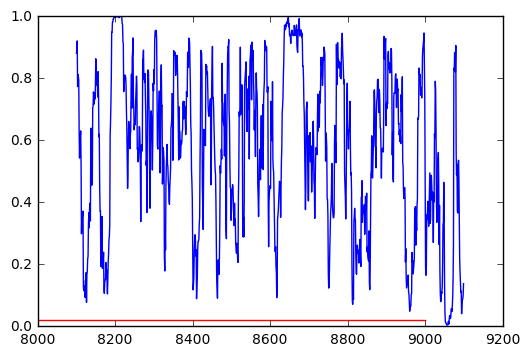

In [17]:
plt.plot(test_points[8000:9000],chi_sq[8000:9000])
a = np.linspace(8000,9000,1000)
th = 0.02*np.ones(a.shape)
plt.plot(a,th,color='red')
plt.show()

In [12]:
f = (np.array(test_points2)[:,0]/10)[:,None][:,0]
c1 = (np.array(con_bd)[:,0])[:,0]
c2 = (np.array(con_bd)[:,1])[:,0]

 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


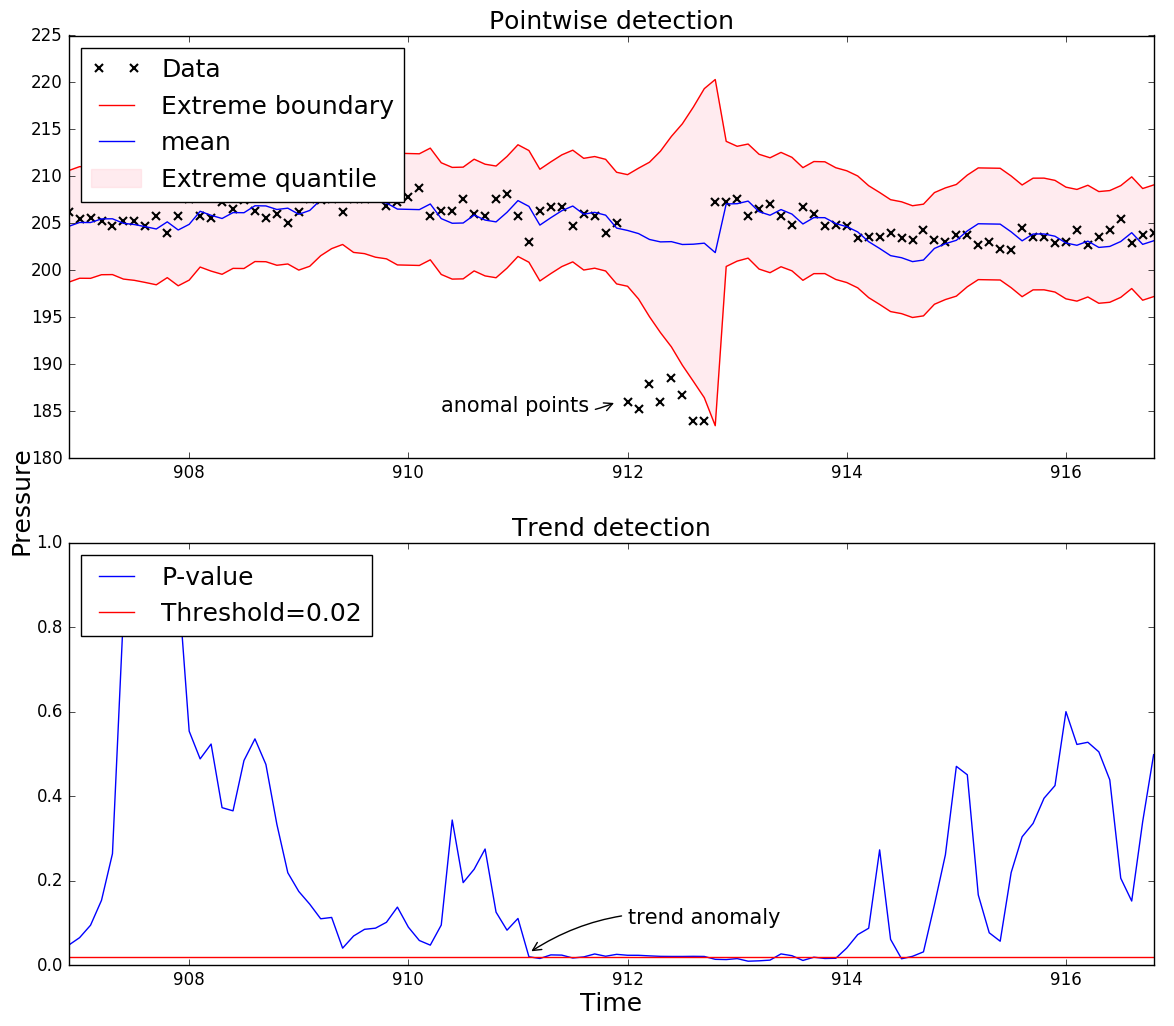

In [21]:
fig = pb.figure(figsize=(14,12))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
    
plt.xlabel('Time',fontsize=18)
plt.ylabel('Pressure',fontsize=18)
#Output 1
ax1 = fig.add_subplot(211)
ax1.set_xlim([906.9,916.8])
ax1.set_title('Pointwise detection',fontsize=18)
ax1.tick_params(labelsize=12)
ax1.plot(x[test_points],p2[test_points],'kx',mew = 1.5,label="Data")
ax1.plot(np.array(test_points2)[:,0]/10,np.array(con_bd)[:,0],color='red',label="Extreme boundary")
ax1.plot(np.array(test_points2)[:,1]/10,np.array(con_bd)[:,1],color='red')
ax1.fill_between(f, c1, c2, color='pink', alpha=0.3,label="Extreme quantile")
ax1.plot(np.array(test_points2)[:,1]/10,(c1+c2)/2,color='blue',label="mean")
ax1.legend(loc=2,fontsize=18)
ax1.annotate('anomal points', xy=(911.9, 186), xytext=(910.3, 185), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

#Output 2
ax2 = fig.add_subplot(212)
ax2.set_xlim([906.9,916.8])
ax2.set_ylim([0,1])
ax2.set_title('Trend detection',fontsize=18)
ax2.tick_params(labelsize=12)
ax2.legend(loc=3)
ax2.plot(x[test_points],chi_sq,label="P-value")
a = np.linspace(906.9,916.8,100)
th = 0.02*np.ones(a.shape)
ax2.plot(a,th,color='red',label="Threshold=0.02")
ax2.legend(loc=2,fontsize=18)
ax2.annotate('trend anomaly', xy=(911.1, 0.03), xytext=(912, 0.1), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
fig.savefig('1.png')
plt.show()